In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

# Load and preprocess data
train_data = pd.read_csv('/content/drive/MyDrive/colab_notebooks/Data/main_dataset.csv')
train_data['Id'] = np.where(train_data['Id'] < 1e-18, 1e-18, train_data['Id'])
train_data['Log_Id'] = np.log10(train_data['Id'])
X = train_data[['Tox', 'Nc', 'Nd', 'Ns', 'Vds', 'Vgs']]
y = train_data['Log_Id']

# Polynomial features and scaling
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Define hyperparameter grid for RandomForestRegressor
param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [5, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'max_samples': [0.5, 0.7, 0.9, None]  # Only used if bootstrap=True
}

# DataFrame to store results
results_df = pd.DataFrame(columns=[
    'n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf',
    'max_features', 'bootstrap', 'max_samples', 'R2', 'MAE'
])

# Randomized search on hyperparameters
random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs = -1),
    param_grid,
    n_iter=40,
    random_state=42,
    n_jobs=-1,
    verbose=5,
    cv=3
)
random_search.fit(X_train, y_train)


Fitting 3 folds for each of 40 candidates, totalling 120 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
48 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 433, in fit
    raise ValueError(
ValueError: `max_sample` cannot be set if `bootstrap=False`.

RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 20, 30, 50],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_samples': [0.5, 0.7, 0.9, None],
                                        'min_samples_leaf': [1, 2, 4, 10],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [100, 300, 500, 700]},
                   random_state=42, verbose=5)

In [19]:
random_search = joblib.load('/content/drive/MyDrive/colab_notebooks/Data/random_search_rf.joblib')

{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': None, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}


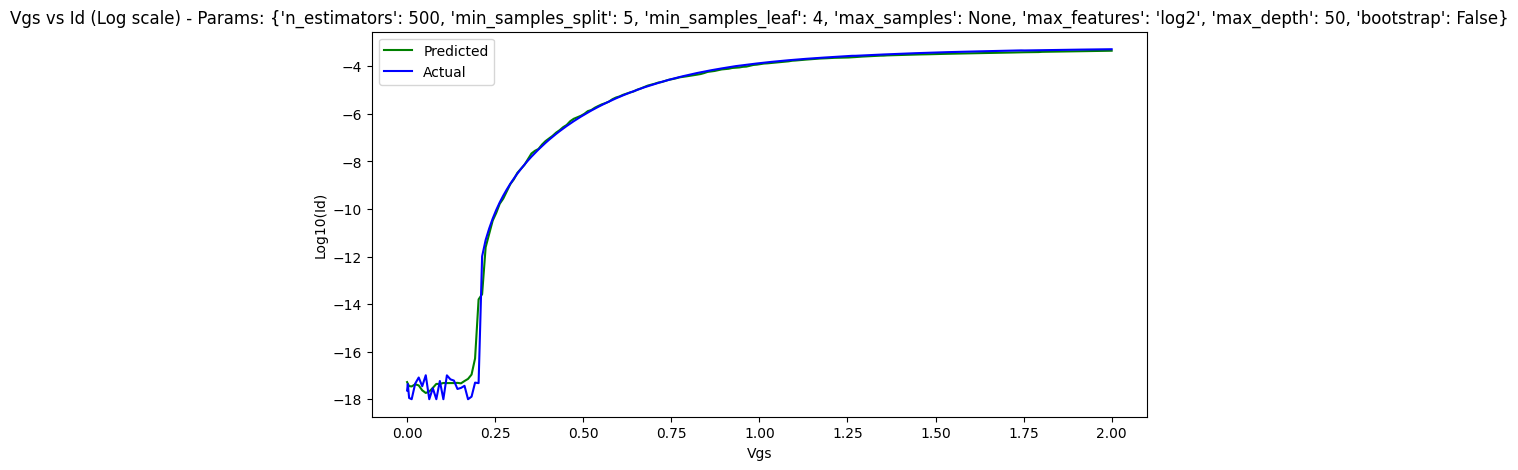

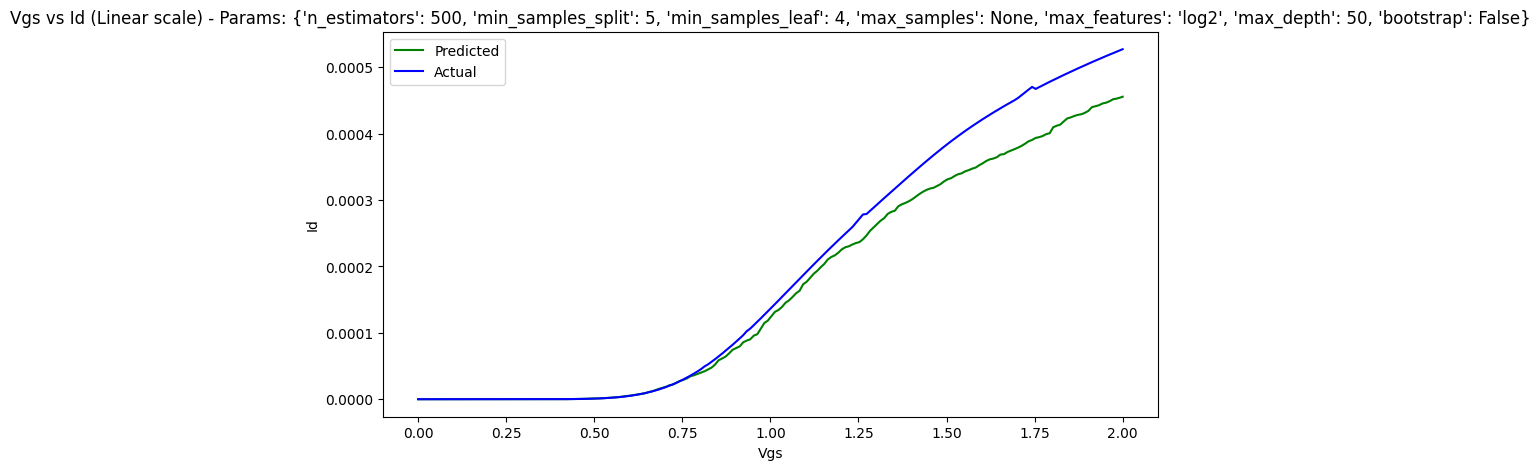

--------------
---------
-----------------

{'n_estimators': 700, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_samples': None, 'max_features': None, 'max_depth': 50, 'bootstrap': False}


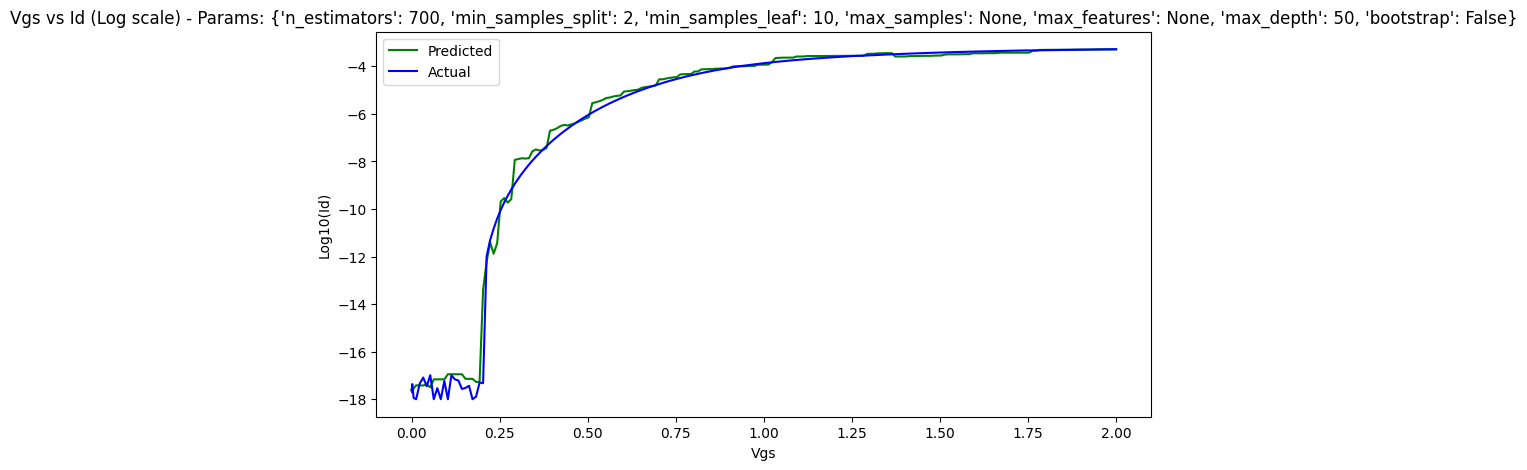

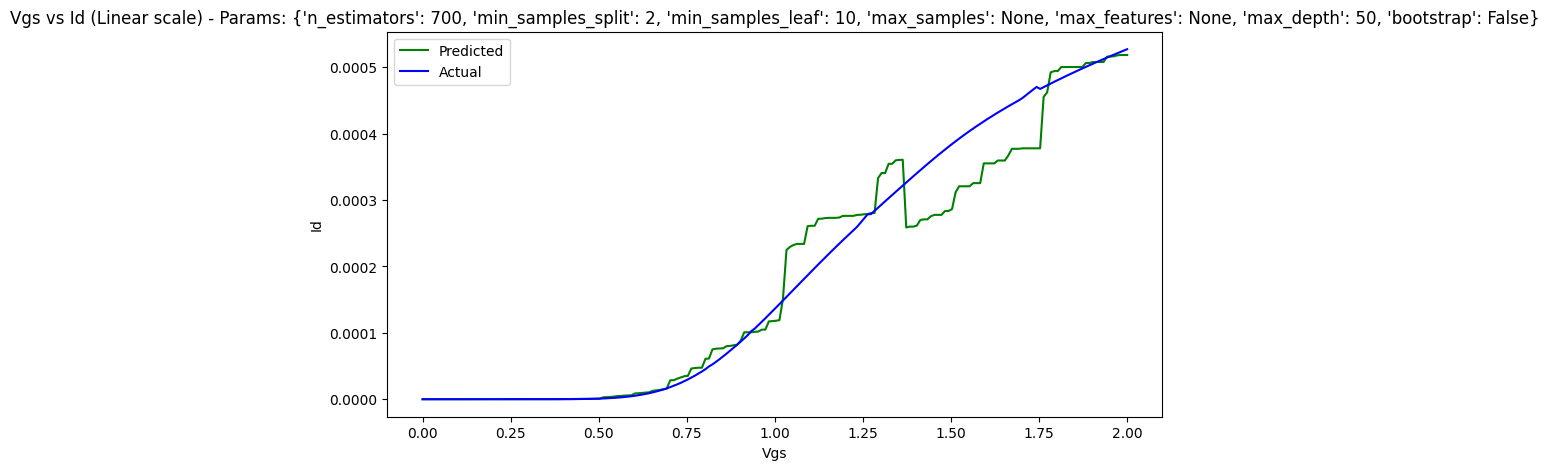

--------------
---------
-----------------

{'n_estimators': 100, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_samples': 0.7, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}


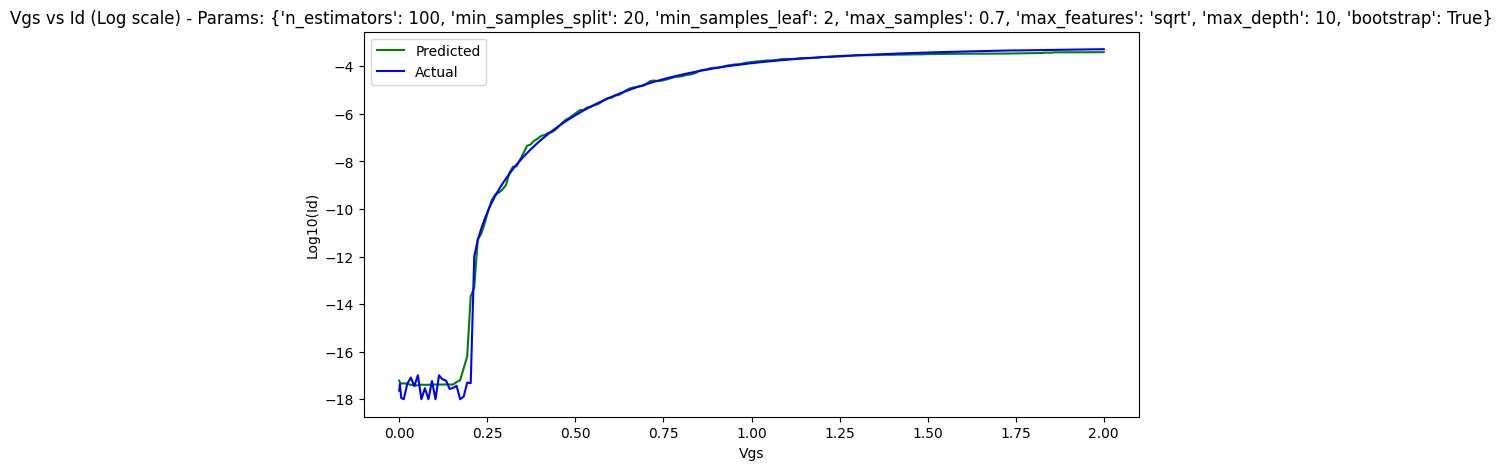

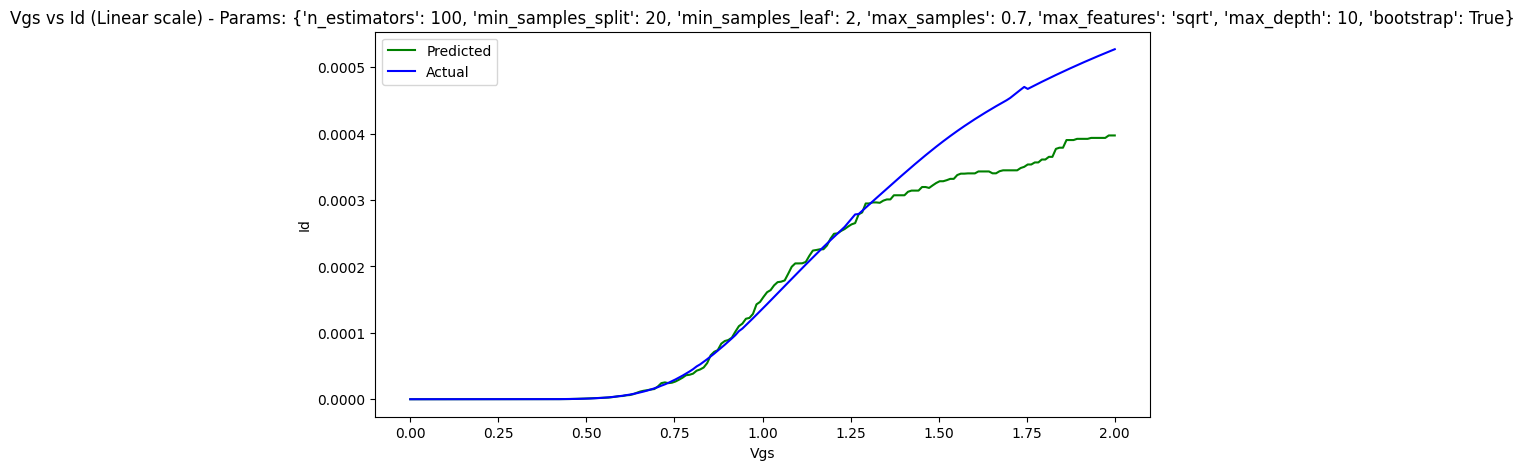

<ipython-input-20-467af8df6734>:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, current_result], ignore_index=True)


--------------
---------
-----------------

{'n_estimators': 500, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_samples': None, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}


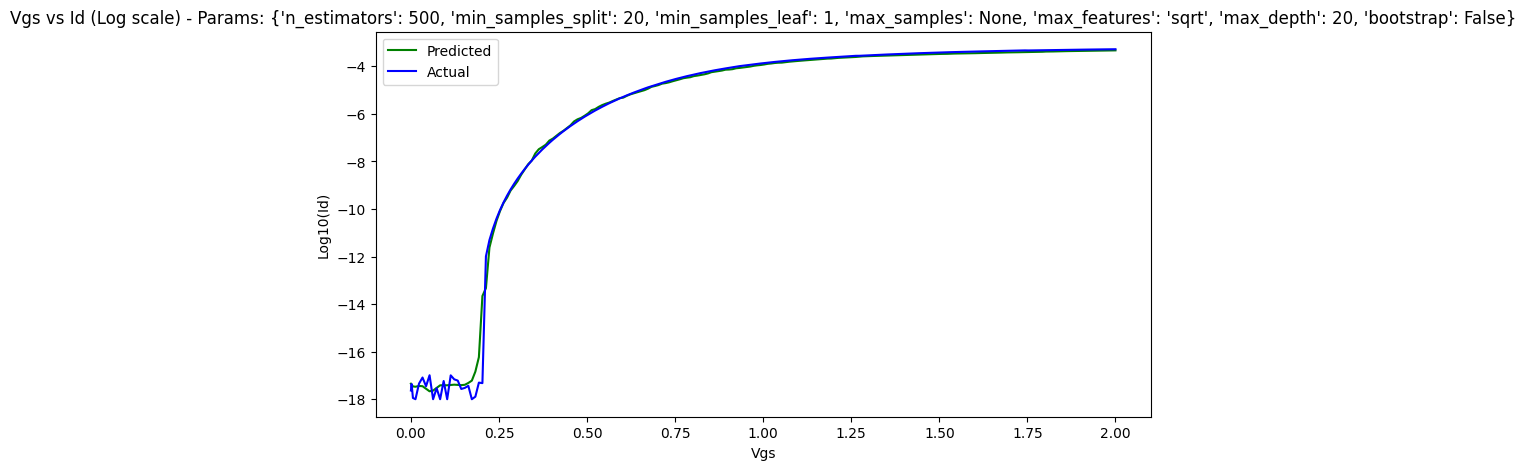

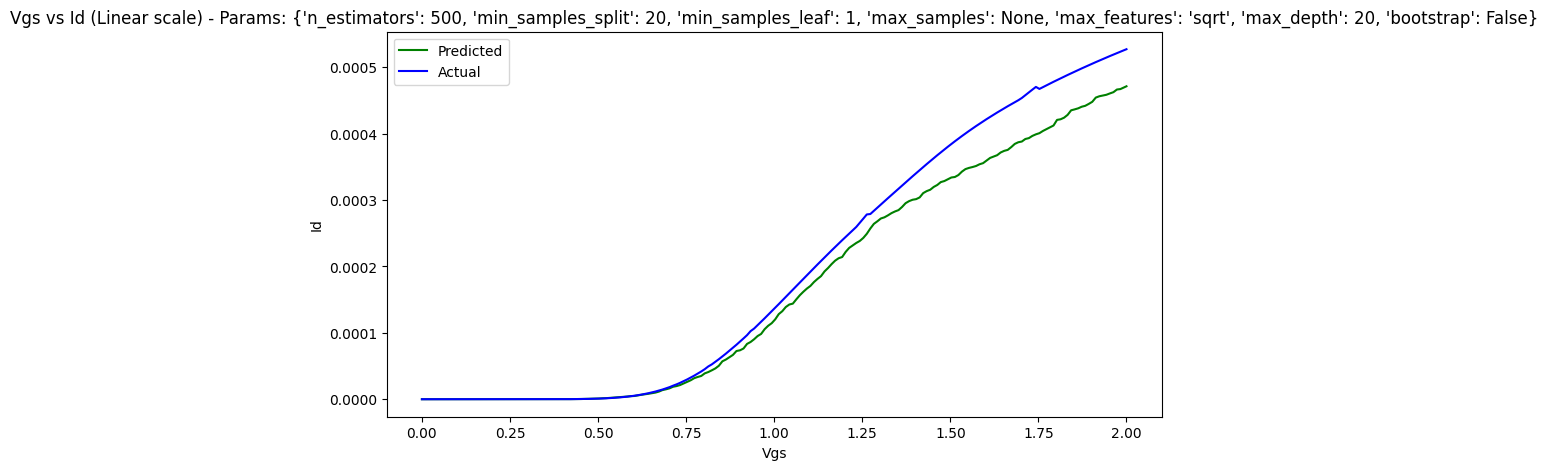

<ipython-input-20-467af8df6734>:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, current_result], ignore_index=True)


--------------
---------
-----------------

{'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_samples': None, 'max_features': None, 'max_depth': 10, 'bootstrap': False}


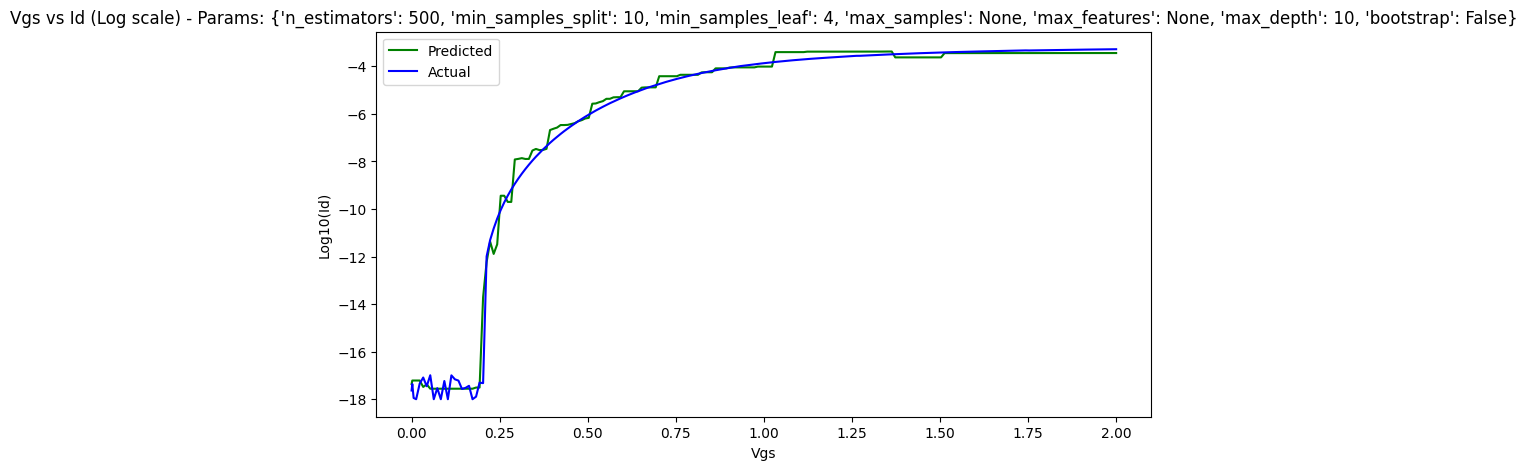

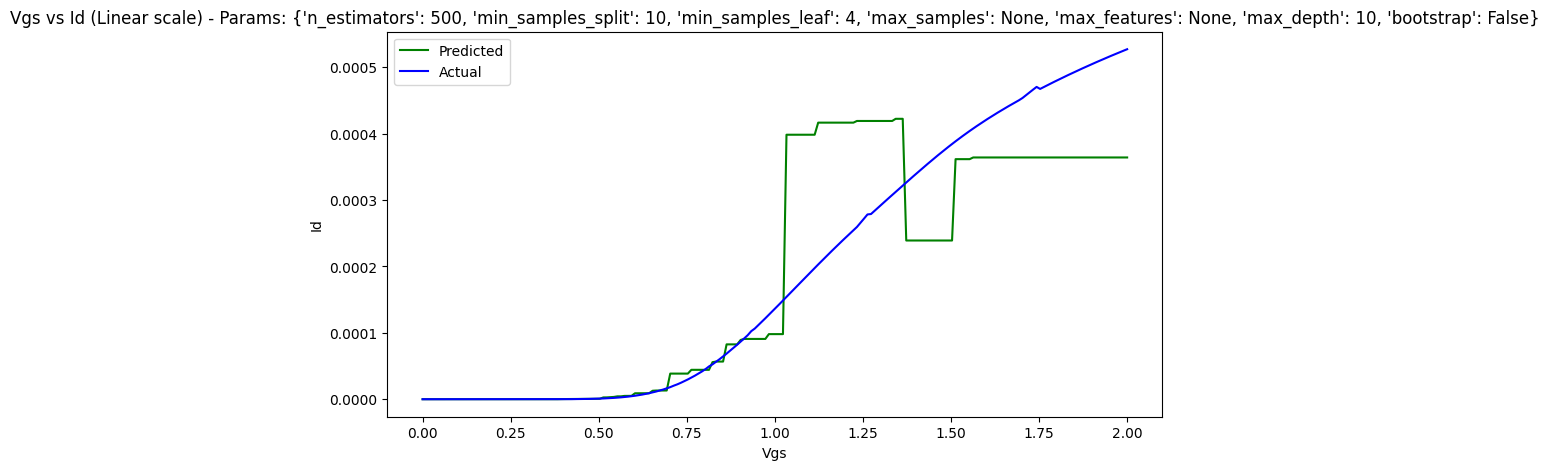

<ipython-input-20-467af8df6734>:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, current_result], ignore_index=True)


--------------
---------
-----------------



In [ ]:

# Loop through each hyperparameter set
for params in random_search.cv_results_['params']:
    # Set up the model with the current parameters
    if not params['bootstrap'] and params['max_samples'] is not None:
        params['max_samples'] = None  # Set max_samples to None if bootstrap is False

    model = RandomForestRegressor(random_state=42, **params, n_jobs = -1)
    model.fit(X_train, y_train)

    print(params)
    # Test on the first test dataset
    y_pred_test = model.predict(X_test)
    r2 = r2_score(y_test, y_pred_test)
    mae = mean_absolute_error(y_test, y_pred_test)

    # Load and preprocess the second test data
    test_data = pd.read_csv('/content/drive/MyDrive/colab_notebooks/Data/test_data.csv').iloc[0:203]
    test_data['Id'] = np.where(test_data['Id'] < 1e-18, 1e-18, test_data['Id'])
    test_data['Log_Id'] = np.log10(test_data['Id'])
    X_test_1 = test_data[['Tox', 'Nc', 'Nd', 'Ns', 'Vds', 'Vgs']]
    y_test_1 = test_data['Log_Id']
    X_test_1_transformed = poly.transform(X_test_1)
    X_test_1_scaled = scaler.transform(X_test_1_transformed)

    # Predict on the second test dataset and evaluate
    y_pred_test_1 = model.predict(X_test_1_scaled)
    r2_test_1 = r2_score(y_test_1, y_pred_test_1)
    mae_test_1 = mean_absolute_error(y_test_1, y_pred_test_1)

    # Log scale plot
    plt.figure(figsize=(10, 5))
    plt.plot(X_test_1['Vgs'], y_pred_test_1, color="green", label="Predicted")
    plt.plot(X_test_1['Vgs'], y_test_1, color="blue", label="Actual")
    plt.title(f'Vgs vs Id (Log scale) - Params: {params}')
    plt.xlabel('Vgs')
    plt.ylabel('Log10(Id)')
    plt.legend()
    plt.show()

    # Linear scale plot
    plt.figure(figsize=(10, 5))
    plt.plot(X_test_1['Vgs'], np.maximum(np.power(10, y_pred_test_1), 1e-18), color="green", label="Predicted")
    plt.plot(X_test_1['Vgs'], np.maximum(np.power(10, y_test_1), 1e-18), color="blue", label="Actual")
    plt.title(f'Vgs vs Id (Linear scale) - Params: {params}')
    plt.xlabel('Vgs')
    plt.ylabel('Id')
    plt.legend()
    plt.show()

    params_copy = params.copy()
    # Ensure max_samples is None if bootstrap is False for recording in results_df
    if not params_copy['bootstrap']:
        params_copy['max_samples'] = None

    current_result = pd.DataFrame({
        'n_estimators': params_copy['n_estimators'],
        'max_depth': params_copy['max_depth'],
        'min_samples_split': params_copy['min_samples_split'],
        'min_samples_leaf': params_copy['min_samples_leaf'],
        'max_features': params_copy['max_features'],
        'bootstrap': params_copy['bootstrap'],
        'max_samples': params_copy['max_samples'], # This line was incomplete
        'R2': r2_test_1,
        'MAE': mae_test_1,
    }, index=[0])

    results_df = pd.concat([results_df, current_result], ignore_index=True)

    print("--------------\n---------\n-----------------\n")

# Display results
print(results_df)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
results_df.to_csv('/content/rf_hyp_tuning_results.csv')